<a href="https://colab.research.google.com/github/chettkulkarni/datasharing/blob/master/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [15]:
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd

from keras.preprocessing import image
import urllib.request
from keras.preprocessing.image import *
import keras
from keras.layers import *

Using TensorFlow backend.


In [3]:
!apt-get install p7zip-full
!p7zip -d file_name.tar.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
/usr/bin/p7zip: cannot read file_name.tar.7z


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = ' https://drive.google.com/open?id=15yUQp_EY3FTWajcTLP7HiZsnfI7WhZEm'
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train-jpg.zip')

import zipfile
with zipfile.ZipFile('train-jpg.zip', 'r') as zip_ref:
    zip_ref.extractall()

KeyboardInterrupt: ignored

In [0]:
link = ' https://drive.google.com/open?id=1sjAShlLYnBQQCHdNSkV4HbJXHP52uOQw'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train-v2.csv')

In [6]:
df = pd.read_csv('train-v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:

x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('train-v2.csv')

In [0]:
def flatten(l):
    result = []
    for sublist in l:    # here shublist is one of the innerlists in each iteration 
        for item in sublist: # One item of a particular inner list 
            result.append(item) #Appending the item to a flat list.
    return result


In [0]:
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

In [10]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

label_map

{'agriculture': 0,
 'artisinal_mine': 10,
 'bare_ground': 2,
 'blooming': 7,
 'blow_down': 15,
 'clear': 16,
 'cloudy': 12,
 'conventional_mine': 4,
 'cultivation': 1,
 'habitation': 14,
 'haze': 13,
 'partly_cloudy': 6,
 'primary': 8,
 'road': 11,
 'selective_logging': 5,
 'slash_burn': 3,
 'water': 9}

In [11]:
inv_label_map

{0: 'agriculture',
 1: 'cultivation',
 2: 'bare_ground',
 3: 'slash_burn',
 4: 'conventional_mine',
 5: 'selective_logging',
 6: 'partly_cloudy',
 7: 'blooming',
 8: 'primary',
 9: 'water',
 10: 'artisinal_mine',
 11: 'road',
 12: 'cloudy',
 13: 'haze',
 14: 'habitation',
 15: 'blow_down',
 16: 'clear'}

In [12]:
for f, tags in tqdm(df_train.values, miniters=5000):
    img = cv2.imread('train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (32, 32)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

100%|██████████| 40479/40479 [00:54<00:00, 745.80it/s]


In [13]:
targets

array([1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
dataSplit = 30000
x_train, x_valid, y_train, y_valid = x_train[:dataSplit], x_train[dataSplit:], y_train[:dataSplit], y_train[dataSplit:]
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(30000, 32, 32, 3) (10479, 32, 32, 3) (30000, 17) (10479, 17)


In [0]:
def build_model():
  classifier = keras.models.Sequential()
  classifier.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3),activation='relu'))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))
  classifier.add(Conv2D(32, (3, 3), activation='relu'))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))
  classifier.add(Flatten())
  classifier.add(Dense(units=128, activation='relu'))
  classifier.add(Dropout(0.5))
  classifier.add(Dense(units=17, activation='sigmoid'))
  return classifier

In [0]:
model=build_model()

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model_history=model.fit(x_train, y_train,batch_size=128,epochs=10,verbose=1,validation_data=(x_valid, y_valid))

Train on 30000 samples, validate on 10479 samples
Epoch 1/10
30000/30000 [==============================] - 46s 2ms/step - loss: 0.1935 - accuracy: 0.9236 - val_loss: 0.1825 - val_accuracy: 0.9261
Epoch 2/10
30000/30000 [==============================] - 46s 2ms/step - loss: 0.1903 - accuracy: 0.9250 - val_loss: 0.1791 - val_accuracy: 0.9288
Epoch 3/10
30000/30000 [==============================] - 46s 2ms/step - loss: 0.1868 - accuracy: 0.9264 - val_loss: 0.1745 - val_accuracy: 0.9312
Epoch 4/10
30000/30000 [==============================] - 49s 2ms/step - loss: 0.1841 - accuracy: 0.9278 - val_loss: 0.1764 - val_accuracy: 0.9295
Epoch 5/10
30000/30000 [==============================] - 45s 2ms/step - loss: 0.1818 - accuracy: 0.9286 - val_loss: 0.1703 - val_accuracy: 0.9324
Epoch 6/10
30000/30000 [==============================] - 45s 2ms/step - loss: 0.1806 - accuracy: 0.9292 - val_loss: 0.1703 - val_accuracy: 0.9326
Epoch 7/10
30000/30000 [==============================] - 45s 2ms/st

(0.0, 1.0)

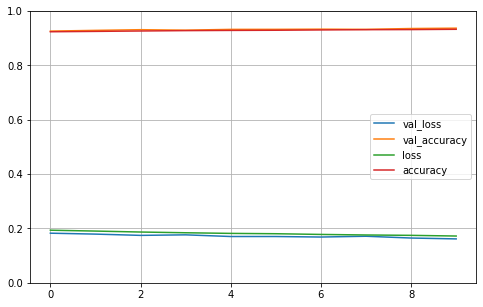

In [22]:
import pandas as pd
pd.DataFrame(model_history.history).plot(figsize=(8,5))
import matplotlib.pyplot as plt

plt.grid(True)
plt.gca().set_ylim(0,1)